In [1]:
from load_modules import *
import copy


In [2]:
plt.rcParams['figure.figsize'] = (14.0, 3.0)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 1

def create_exp(x):
    return np.random.uniform(80,100)*np.exp(np.linspace(1,np.random.uniform(-1,-50),len(x))) 

def create_poly(x):
    max_power = np.random.randint(3,7)
    y = np.ones(x.shape) * np.random.uniform(20,40) + (max_power-1) * 30
    for power in range(1, max_power):
        y -= np.linspace(-1,1,len(x))**power * np.random.uniform(20,40)
    return y

def create_gaus(x):
    mu = np.random.uniform(600,800) * (end-start) / steps
    sigma = np.random.uniform(200,500)
    return np.exp(-0.5* ((x - mu)**2 / sigma**2)) * np.random.uniform(20,40)

def norm(e):
    return (e - np.min(e)) / (np.max(e) - np.min(e))

def create_dummy_spectra(expo=True, poly=True, gaus=True, raman=True):
    global raw_lst
    raw_lst = []
    for _ in range(100):
        photo  = np.zeros(x.shape)
        if expo:
            photo += create_exp(x)
        if poly:
            photo += create_poly(x)
        if gaus:
            photo += create_gaus(x)
        photo -= min(-5, np.min(photo))
        raw = copy.copy(photo)
                
        if raman:
            for _ in range(20):
                FWHM_spike = np.random.uniform(7,80)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(5,10) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
            for _ in range(10):
                FWHM_spike = np.random.uniform(7,40)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(10,20) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
            for _ in range(6):
                FWHM_spike = np.random.uniform(7,40)
                raman_mu = int(n*np.random.uniform(0.1,0.9))
                raw +=  np.random.uniform(20,80) * LSQ.gaussian(x, np.array([raman_mu]), np.array([FWHM_spike / (2 * np.sqrt(2 * np.log(2)))])).reshape(-1)
        
        raw += np.random.random(x.shape) * 5
        raw_lst.append((raw, photo))
    raw_lst = np.array(raw_lst)


In [3]:
end = 2000
start = 80
steps = 1250
n = end-start
x = np.linspace(start, end, steps)

raw_lst = []
create_dummy_spectra(expo=True, poly=True, gaus=True, raman=True)


0.0% progress


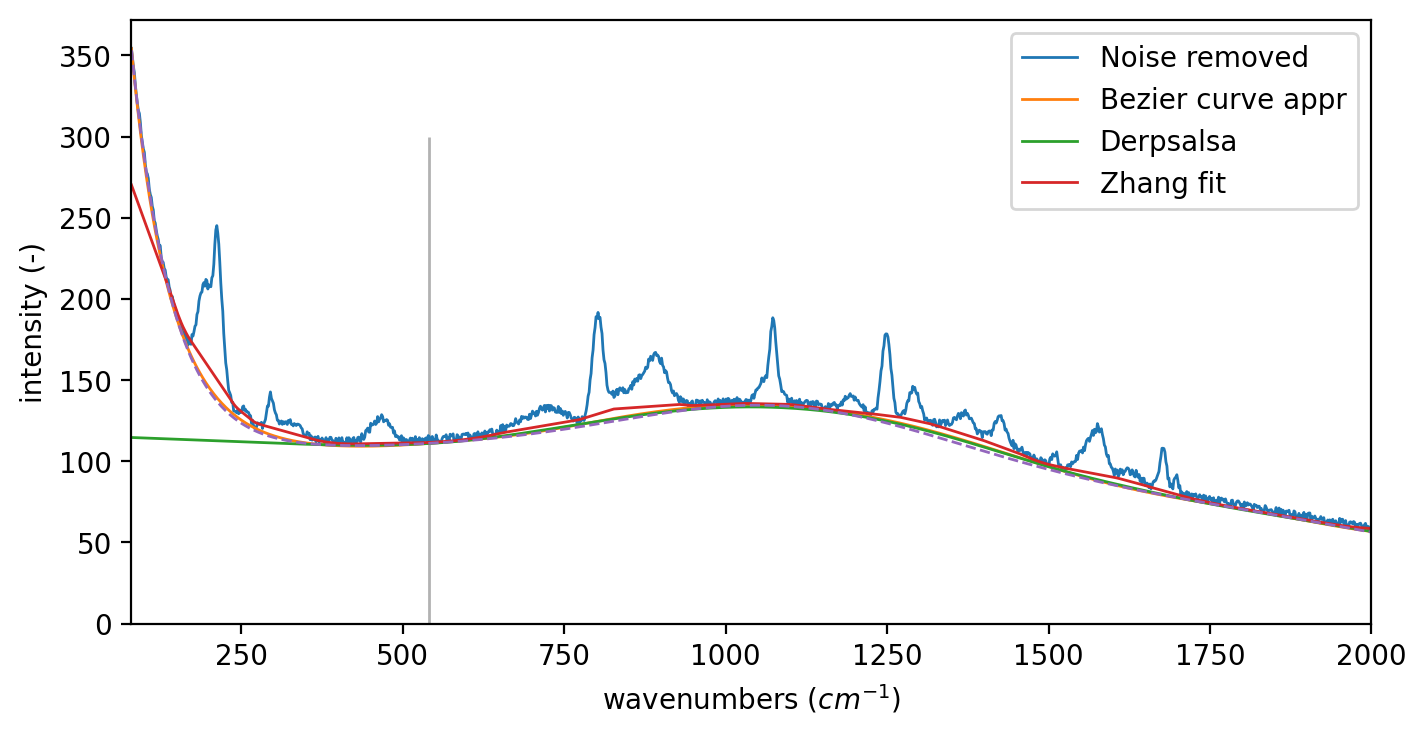

In [9]:
from BaselineRemoval import BaselineRemoval

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1

split = splitting.split(x, size=x.shape[0], FWHM=400, segment_width=450, algorithm="Bezier curve")

proposed_error = []
ALS_error = []
zhang_error = []

LEFT = 300

def calc_error(raw, photo):
    return [error.MSE(raw, photo), error.MSGE(photo), error.MAPE(raw, photo)]

def calc_error_optimum(photo_org, photo):
    return [error.MSE(photo_org, photo), error.TMSGE(photo_org, photo), error.MAPE(photo_org, photo)]

for j, (raw, photo_org) in enumerate(raw_lst):
    photo = split(raw.reshape(1,-1))[0]
    photo_ALS = derpsalsa.derpsalsa_baseline(x, raw, als_lambda=1e3, als_p_weight=1e-5, display=0)
    baseObj = BaselineRemoval(raw)
    photo_zhangfit = raw - baseObj.ZhangFit(lambda_=50, itermax=30)

    proposed_error.append(calc_error_optimum(photo_org, photo) + calc_error_optimum(photo_org[:LEFT], photo[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo[LEFT:]))
    ALS_error.append(calc_error_optimum(photo_org, photo_ALS) + calc_error_optimum(photo_org[:LEFT], photo_ALS[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo_ALS[LEFT:]))
    zhang_error.append(calc_error_optimum(photo_org, photo_zhangfit) + calc_error_optimum(photo_org[:LEFT], photo_zhangfit[:LEFT]) + calc_error_optimum(photo_org[LEFT:], photo_zhangfit[LEFT:]))
    
#     print("new", ("{:.3f} \t"*9).format(*proposed_error[-1]))
#     print("Zha", ("{:.3f} \t"*9).format(*zhang_error[-1]))
#     plt.plot(x, raw, label="Noise removed")
#     plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
#     plt.plot(x, photo_ALS, label="Derpsalsa")
#     plt.plot(x, photo_zhangfit, label="Zhang fit")
#     plt.plot(x, photo_org, "--")
#     plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
#     plt.ylim(0)
#     plt.xlim(x[0], x[-1])
#     plt.xlabel(r"wavenumbers ($cm^{-1}$)")
#     plt.ylabel("intensity (-)")
#     plt.legend()
#     plt.show()
#     break
    
    if not j % 100:
        print(f"{j/len(raw_lst)*100}% progress")
        plt.plot(x, raw, label="Noise removed")
        plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
        plt.plot(x, photo_ALS, label="Derpsalsa")
        plt.plot(x, photo_zhangfit, label="Zhang fit")
        plt.plot(x, photo_org, "--")
        plt.vlines(x[LEFT], 0, 300, 'k', alpha=0.3)
        plt.ylim(0)
        plt.xlim(x[0], x[-1])
        plt.xlabel(r"wavenumbers ($cm^{-1}$)")
        plt.ylabel("intensity (-)")
        plt.legend()
    plt.show()
    if j > 500:
        break


In [10]:
error1 = np.array(copy.copy(proposed_error))
error2 = np.array(copy.copy(ALS_error))
error3 = np.array(copy.copy(zhang_error))

In [11]:
# print(f"{np.mean(error1, 0)},\t {np.std(error1, 0)}")
# print(f"{np.mean(error2, 0)},\t {np.std(error2, 0)}")
# print(f"{np.mean(error3, 0)},\t {np.std(error3, 0)}")

In [12]:
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 1

error_lst = ["MSE","(T)MSGE", "MAPE"]

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    violin['cmeans'].set_edgecolor('m')
    violin['cmeans'].set_linewidth(2)
    violin["cbars"].set_alpha(0)
    return violin

def change_box(box):
    for pc in box["medians"]:
        pc.set_color("r")
        pc.set_alpha(1)
            
    for line in ["whiskers", "boxes", "caps"]:
        for pc in box[line]:
            pc.set_linewidth(0.5)
    return box

def plot_results(error_n=0):
    global labels 
    labels = []

    add_label(plt.violinplot(error1[:,error_n::3], positions=[0,3,6],  showmeans=True), "new")  
    add_label(plt.violinplot(error2[:,error_n::3], positions=[1,4,7], showmeans=True), "ALS")
    violin = add_label(plt.violinplot(error3[:,error_n::3], positions=[2,5,8], showmeans=True), "Zhang")

    change_box(plt.boxplot(error1[:,error_n::3], positions=[0,3,6]))
    change_box(plt.boxplot(error2[:,error_n::3], positions=[1,4,7]))
    box = change_box(plt.boxplot(error3[:,error_n::3], positions=[2,5,8]))

    labels.append((violin["cmeans"], "mean"))
    labels.append((box["medians"][0], "median"))

    plt.legend(*zip(*labels))
    plt.xticks(ticks=range(1,9,3), labels=["total","left","right"])
    plt.ylabel(error_lst[error_n])
#     plt.yscale("log")
    plt.ylim(0, 3*np.max(error1[:,error_n::3]))
    plt.show()


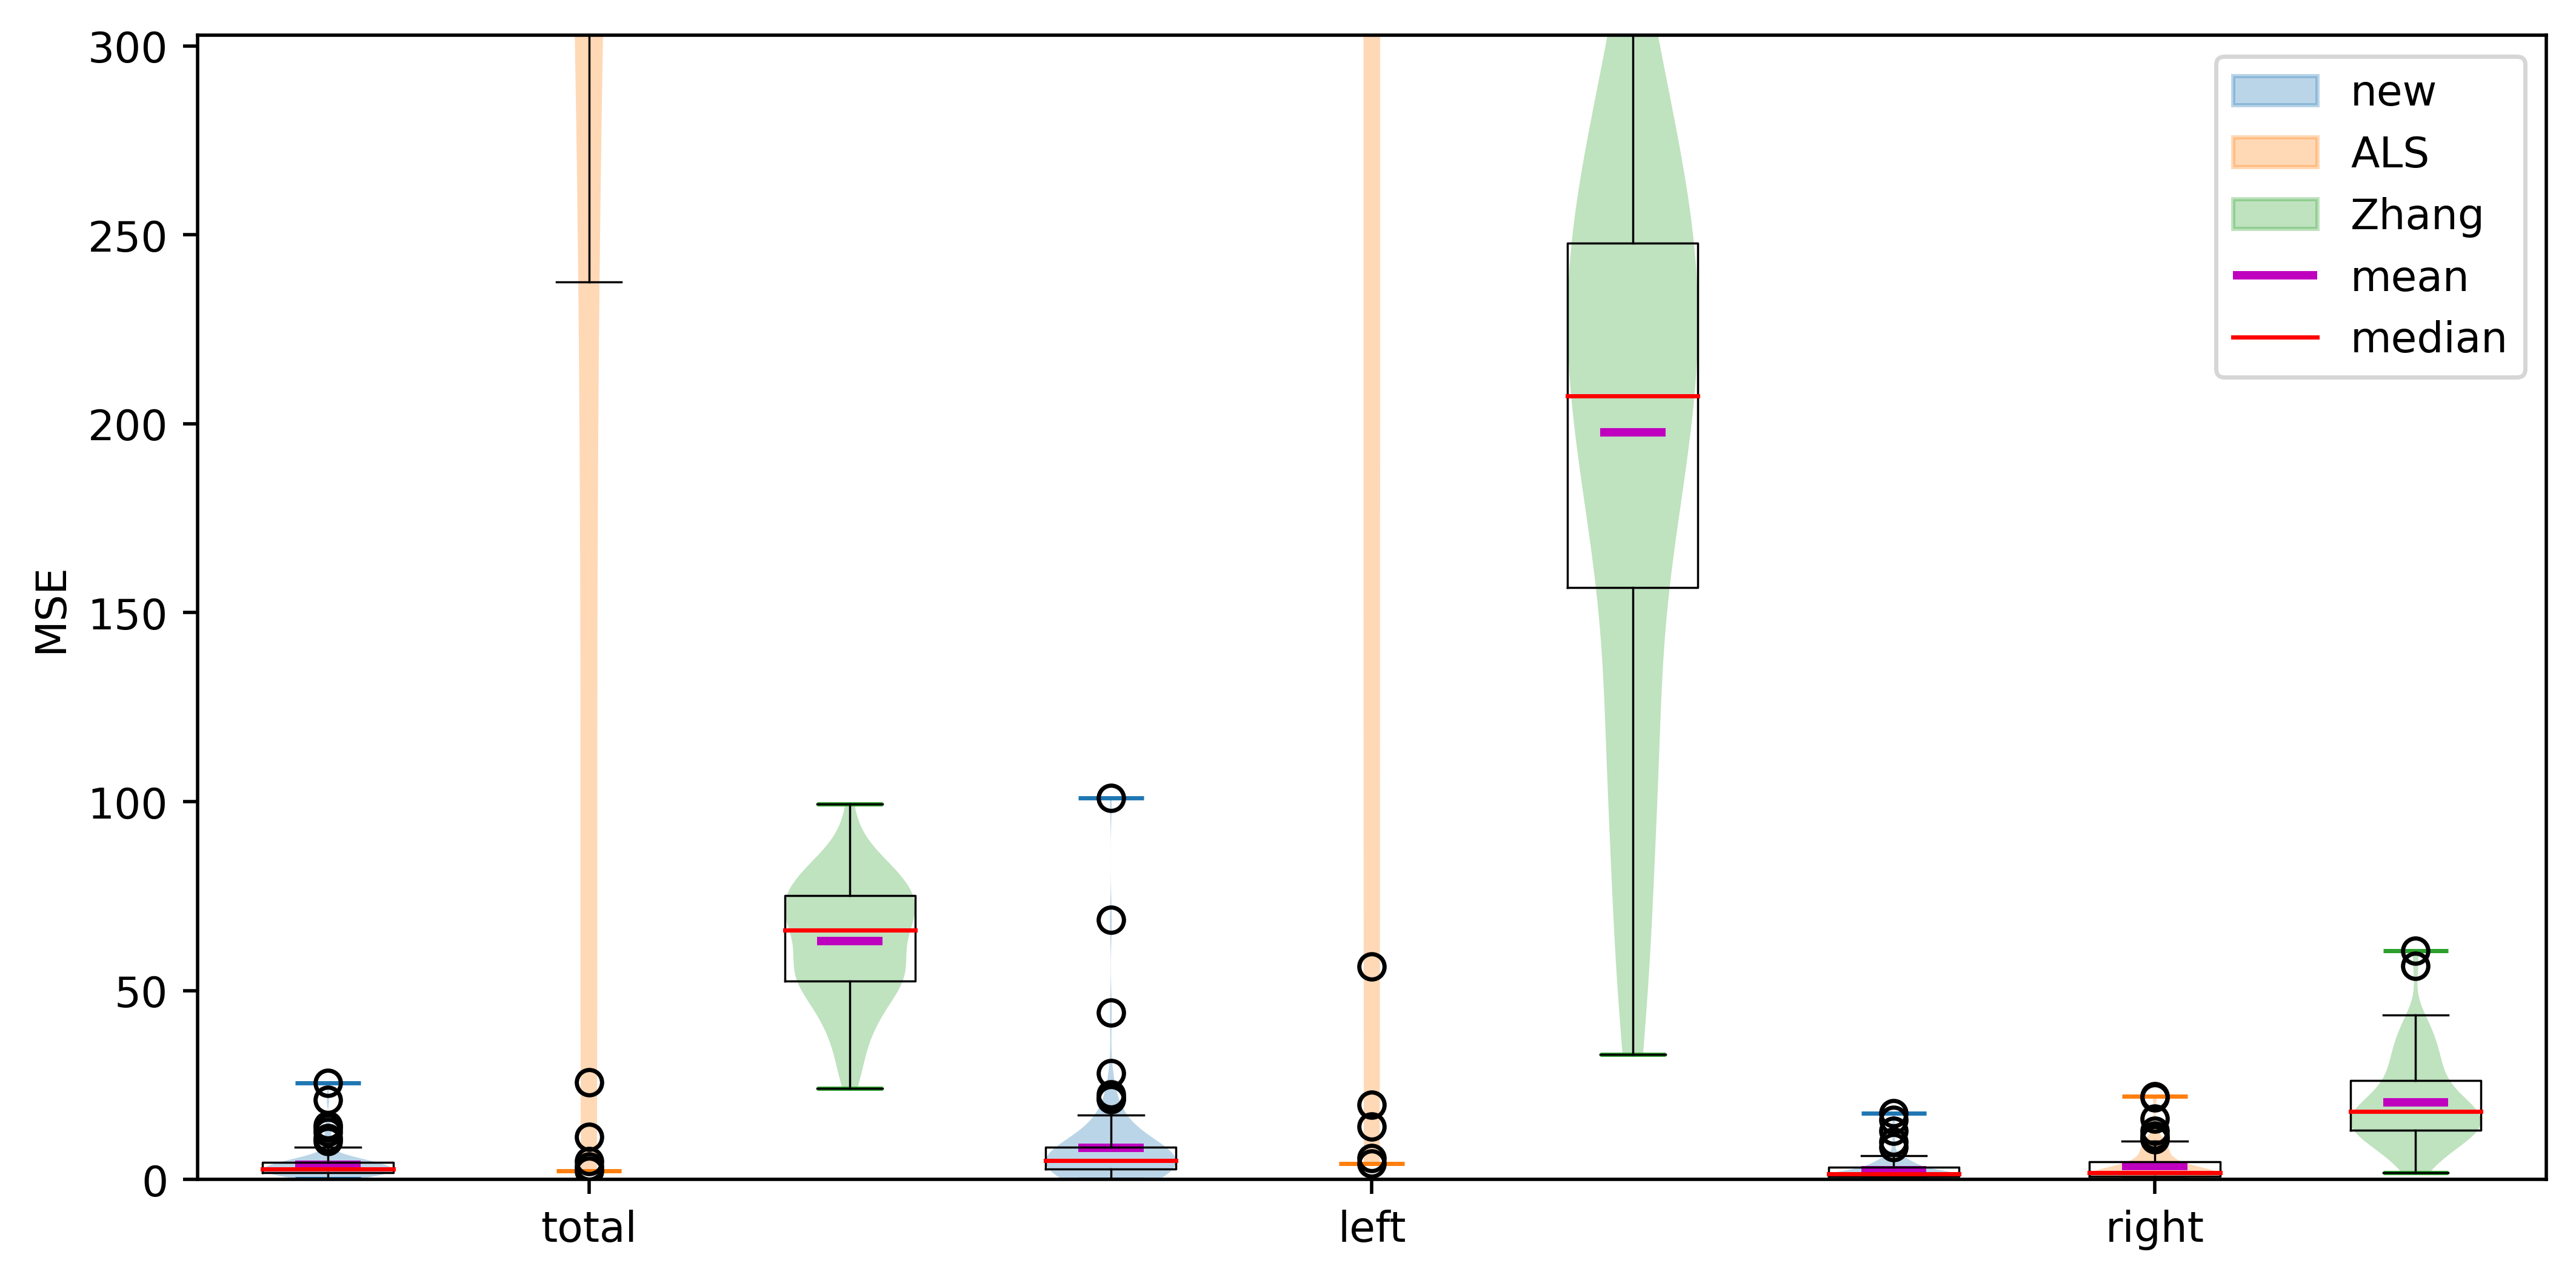

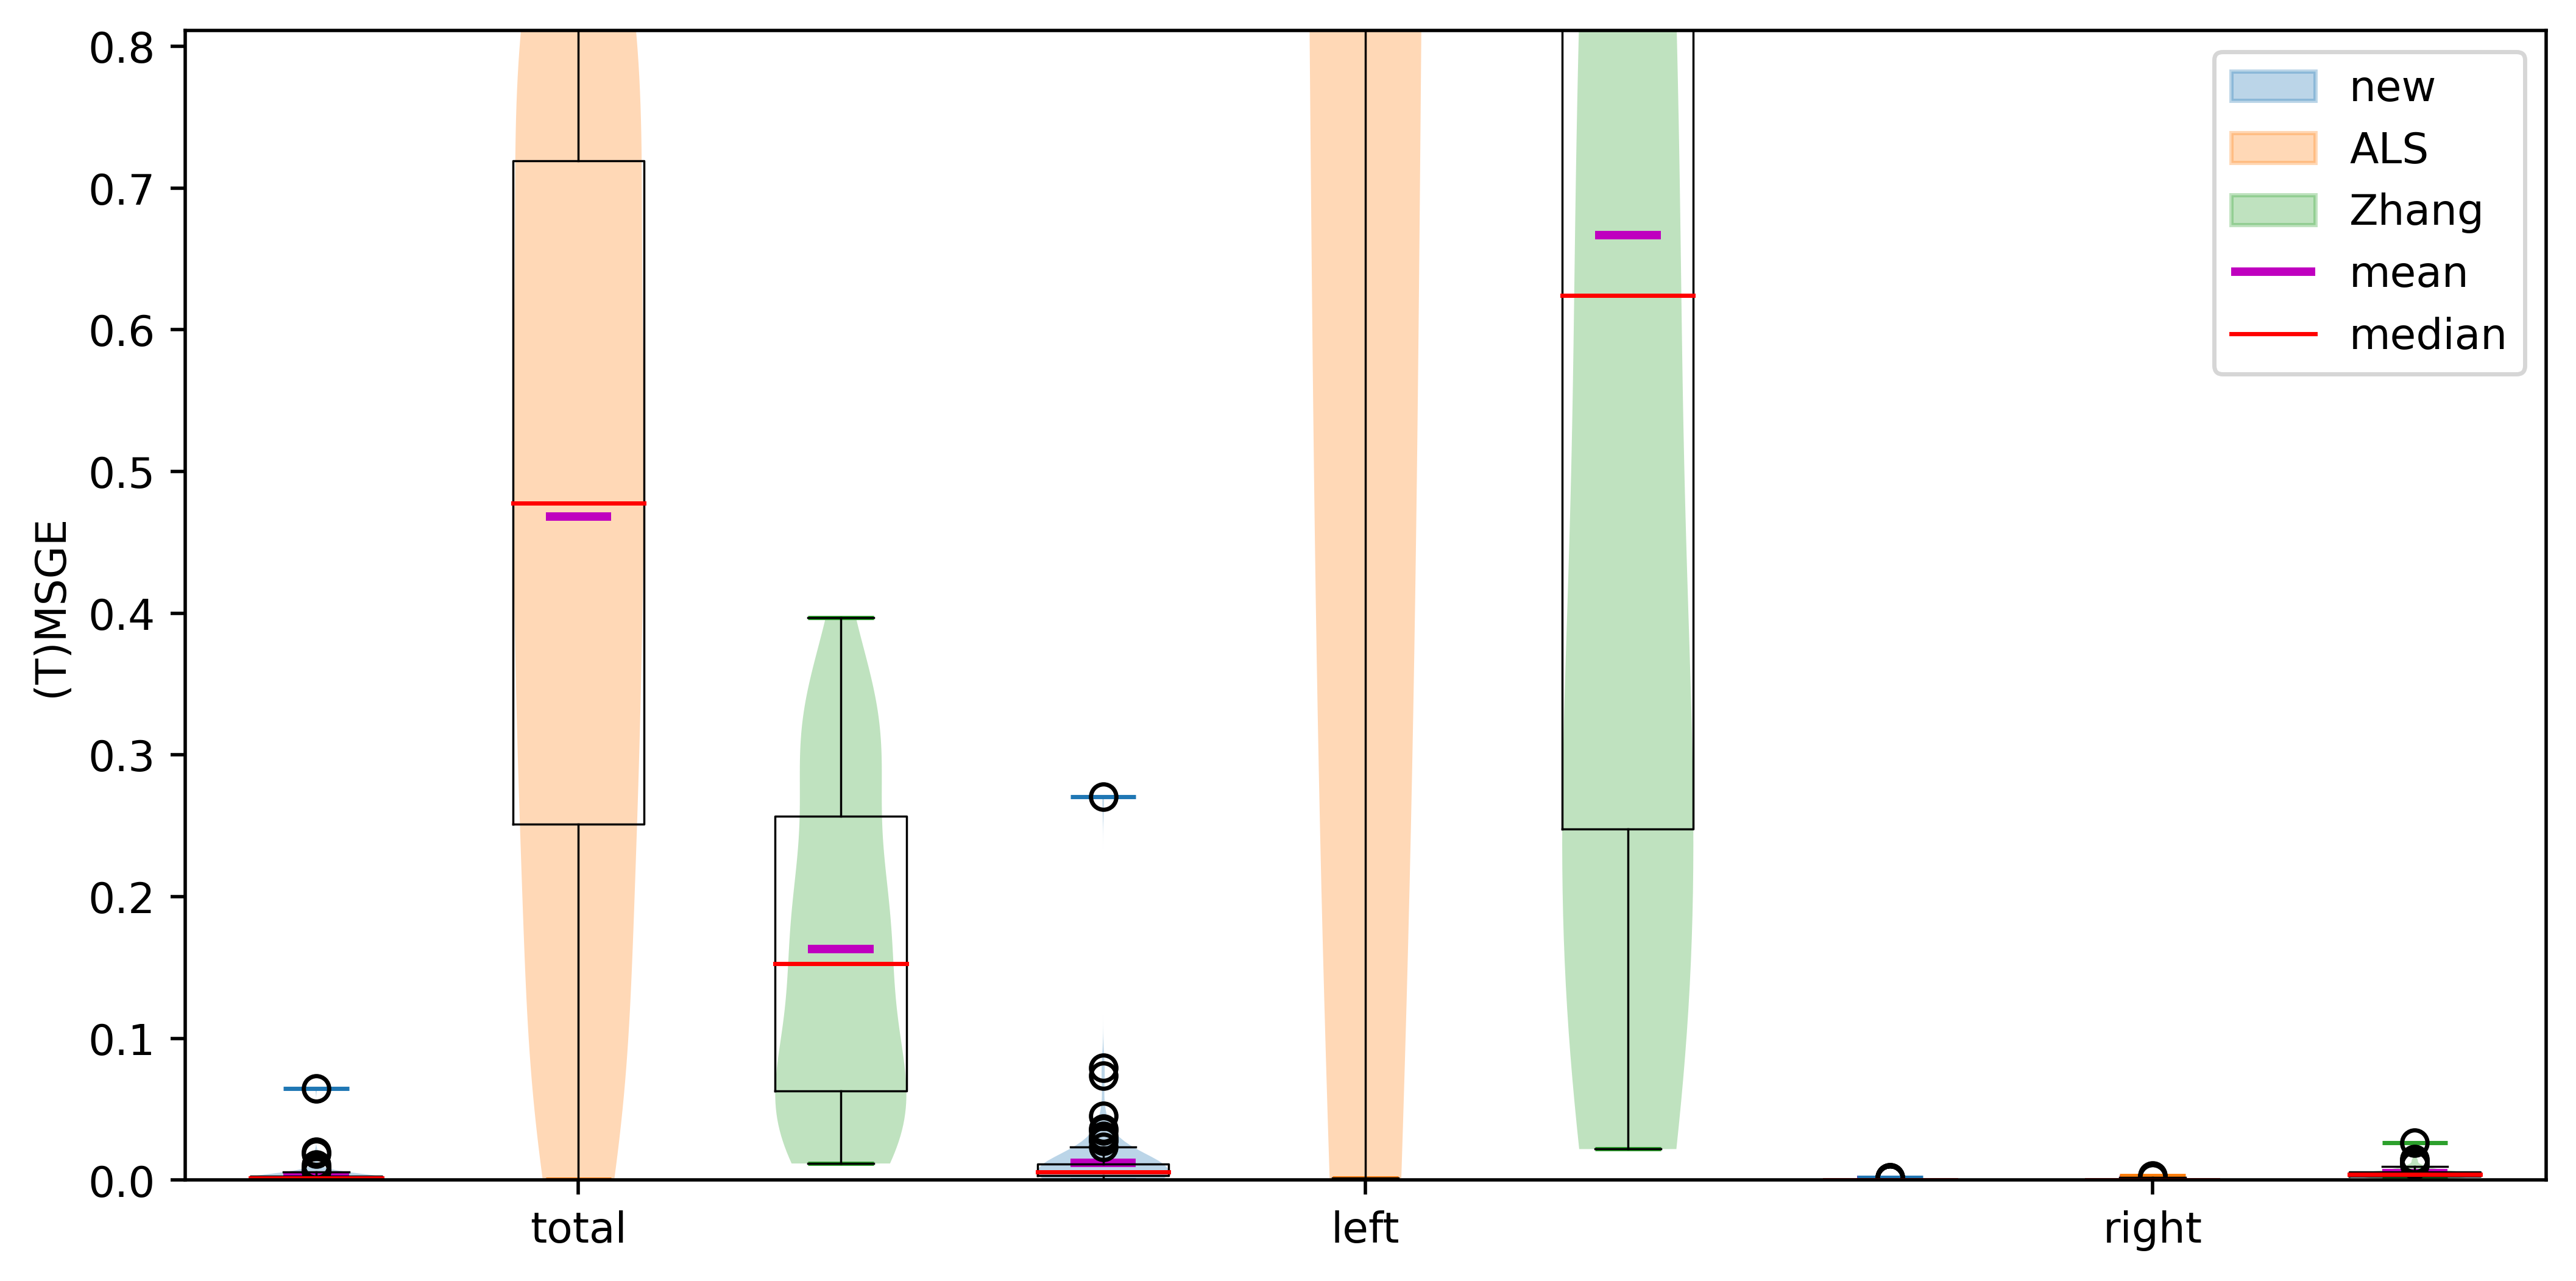

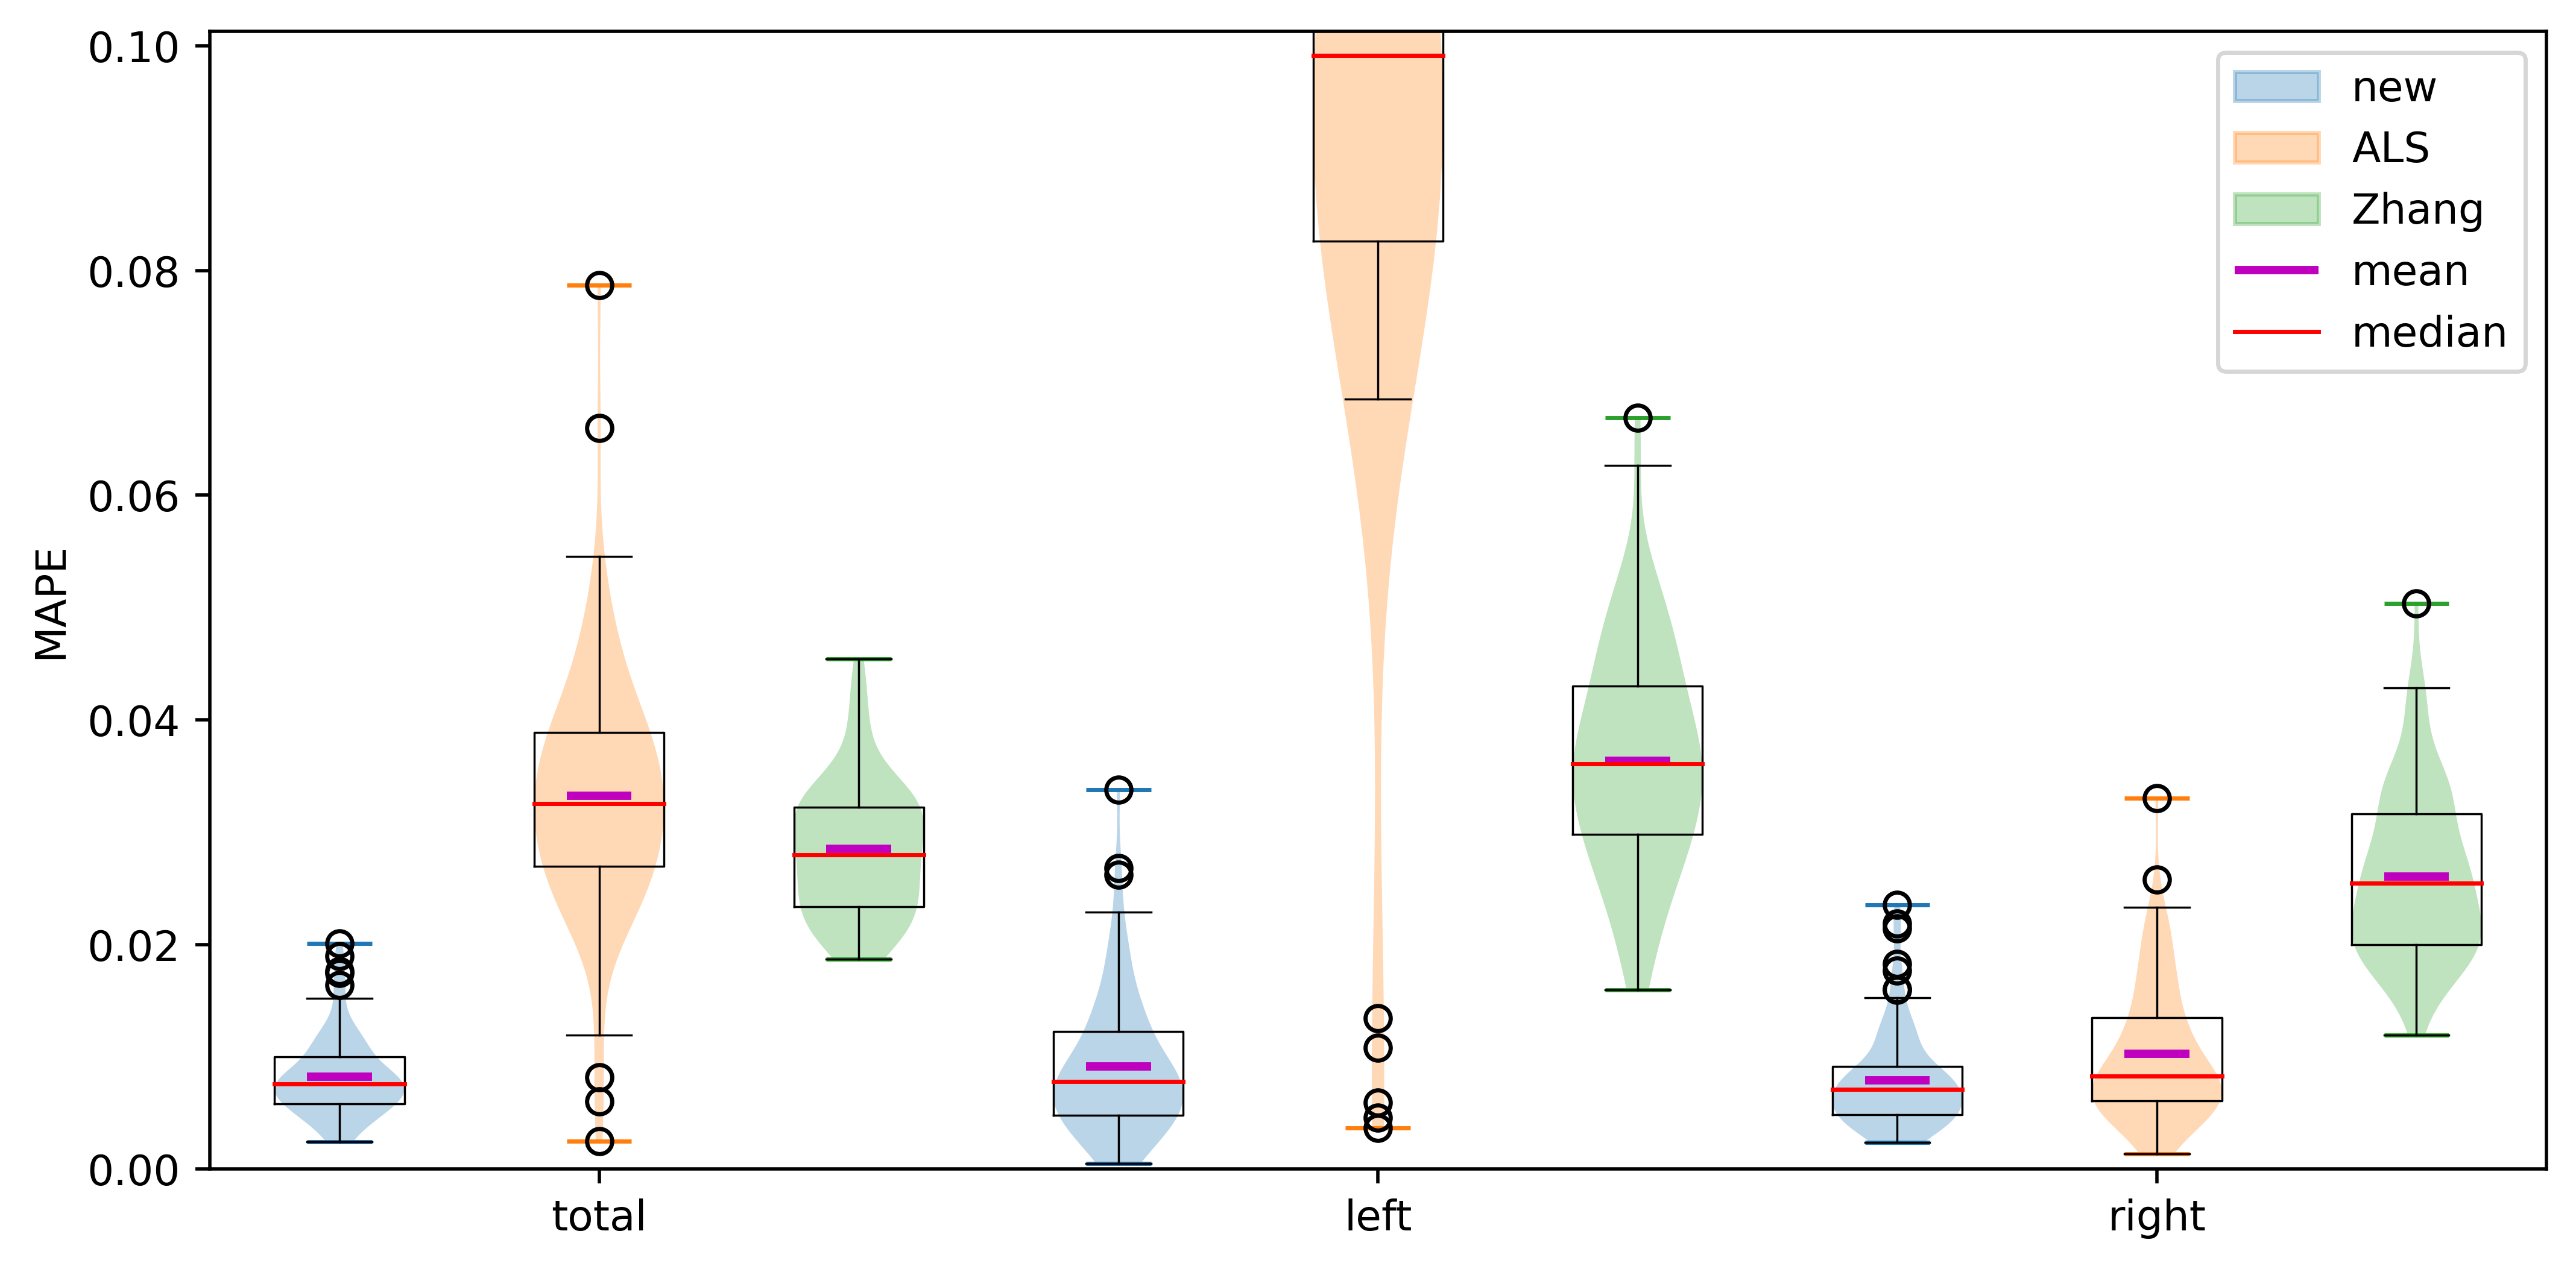

In [13]:
plot_results(0)
plot_results(1)
plot_results(2)